# CSMODEL
### Project 1 - Group 5
Members:
- Alon-alon, Jason Miguel E.
- Escalona, Jose Miguel A.
- Llorca, Marcelino Francis S.

### 1. Dataset Representation

- About the Dataset<br>

The data was provided by Our World in Data (OWID). The file contains different data values that could help paint a better image of a country’s status for COVID-19. The version used in this project will be the July 15, 2021 release of the dataset, however OWID attempts both daily and weekly update of data whenever possible, thus ensuring that the data they provide is the latest possible.

- Collection Process and its Implications<br>

The collection was done by the Our World in Data Group which is a research group that focuses on research and aggregation of data in a single accessible repository for the purposes of getting a better picture or even solving world problems that can benefit all of mankind. For the specific dataset, they made use of all possible available data that is publicly released by governments of all nations in the world. According to OWID, the data was collected from the following sources which include:
    
1. COVID-19 Data Repository of Johns Hopkins University
2. National Government Reports
3. Oxford COVID-19 Government Response Tracker, Blavatnik School of Government
4. United Nations Data (for demographics related data)
5. World Bank Data (for demographics related data)
    
The data implies that the data presented assumes to be the latest data possible, with its validity ultimately depending on each reporting government's transparency and accuracy with the data they are reporting publicly and to John Hopkins University.
    <br>
- Structure of Dataset of the File<br>

    The dataset's structure consists of 102,475 observations with 60 variables available. The structure goes on every country's date when it reported either its first COVID-19 case or first COVID-19 test. The dataset was already distributed publicly on a single file containing all of the relevant information possible. There is however other datasets which contain specific and specialized versions of the current dataset we are using that is also available for use on OWID's Github repository.
    
    | iso_code | continent | location | date | data1 | ... | dataX |
    | --- | --- | --- | --- | --- | --- | --- |
    | PHL | Asia | Philippines | 0000-00-01 | data | ... | dataX |
    | PHL | Asia | Philippines | 0000-00-02 | data | ... | dataX |
    | JPN | Asia | Japan | 0000-00-01 | data | ... | dataX |
    | JPN | Asia | Japan | 0000-00-02 | data | ... | dataX |
    | SGP | Asia | Singapore | 0000-00-01 | data | ... | dataX |
    | SGP | Asia | Singapore | 0000-00-02 | data | ... | dataX |
    | SGP | Asia | Singapore | 0000-00-03 | data | ... | dataX |

    The list of locations are a mixture of continents and actual countries, as recognized by OWID, which may or may not be legally recognized by the international community.
    <br>
- About the Variables<br>
    
    The dataset has 60 variables, most of which relate to COVID-19 related numbers such as cases, deaths, recoveries, vaccinations among others, as well as demographic data such as GDP per capita, HDI, median age, population, population density among others.

In [1]:
print("LOADING LIBRARIES...")
import math #MATH
import re #REGEX
import numpy as np #NUMPY
import pandas as pd #PANDAS
import matplotlib.pyplot as plt #PLOT MATPLOTLIB
import matplotlib.figure as fig #FIGURE MATPLOTLIB
import scipy.stats as stat

bar = "================================="
automated = True #Manual entry or pre-defined entries
print("AUTOMATED MODE:",automated)

#Code for data preparation
raw_df = None
if(not automated):
    filename = input("Enter Filename of CSV file (including .csv): ")
    raw_df = pd.read_csv(filename)
else:
    raw_df = pd.read_csv("COVID_7_15.csv")

print("Raw Dataframe Shape:", raw_df.shape,"\n",bar)
print(raw_df.info())

LOADING LIBRARIES...
AUTOMATED MODE: True
Raw Dataframe Shape: (102475, 60) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102475 entries, 0 to 102474
Data columns (total 60 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               102475 non-null  object 
 1   continent                              97689 non-null   object 
 2   location                               102475 non-null  object 
 3   date                                   102475 non-null  object 
 4   total_cases                            98594 non-null   float64
 5   new_cases                              98591 non-null   float64
 6   new_cases_smoothed                     97581 non-null   float64
 7   total_deaths                           88371 non-null   float64
 8   new_deaths                             88527 non-null   float64
 9   new_deaths_smoothed                    97581 non

### 2. Data Cleaning

Given that there are a lot of nations and variables to consider, it has been decided to reduce to scope of nations to just the ASEAN nations as well as the World as a baseline. The consideration for ASEAN nations was made because of the following reasons:

1. Near proximity
2. Economic integration
3. Similar level economies and populations

This could help us determine the COVID-19 status of the Philippines to its neighbors as well as the World if ever it is applicable.

The most of the columns are to be ommitted since it contains pre-treated values, specialized values, or varying values (in terms of the unit of measurement).

The columns that were retained:

|Column/Variable|Definition|From|
|---|---|---|
|total_cases|Total confirmed cases of COVID-19|COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
|new_cases|New confirmed cases of COVID-19|COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
|total_deaths|Total deaths attributed to COVID-19|COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
|new_deaths|New deaths attributed to COVID-19|COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University
|total_vaccinations|Total number of COVID-19 vaccination doses administered|National government reports
|people_vaccinated|Total number of people who received at least one vaccine dose|National government reports
|people_fully_vaccinated|Total number of people who received all doses prescribed by the vaccination protocol|National government reports
|new_vaccinations|New COVID-19 vaccination doses administered (only calculated for consecutive days)|National government reports
|stringency_index|Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)|Oxford COVID-19 Government Response Tracker, Blavatnik School of Government
|population|Population in 2020|United Nations, Department of Economic and Social Affairs, Population Division, World Population Prospects 2019 Revision

The script below crunches the raw data and produces a covid_df containing:
1. ASEAN COVID-19 Data (Containing 10 Countries, including the Philippines)
2. Philippine COVID-19 Data

Do note however that any observation on a certain day that does not meet the required number of observations (i.e. countries that reported that day) will be automatically omitted from the resulting group dataframe. This was done in order to prevent outliers in the data and to reduce the erraticness of the output which matters since most of the data is of sum and mean value nature.

In [2]:
#CSMODEL: COVID-19 Dataset
#Crunches data of selected countries to a grouped one

#GLOBAL VARIABLES
checkpoint = False
print("CHECKPOINT:",checkpoint)
NaN = float("nan")
group_pop = 0 #Placeholder for the population of group of nations specified.

#CUSTOM FUNCTIONS
def listDates(df): #Sorts the 'date' column of a given DataFrame and returns it.
    return np.sort((df['date'].unique()),kind='mergesort')
def fillZeros(size): #Returns a list of zeros from a specified size
    return np.zeros(size).tolist()
def writeCheckpoint(df, filename): #Writes a given DataFrame to a CSV file
    if(checkpoint):
        print("WRITING CHECKPOINT...")
        df.to_csv(filename+".csv",index=False)
        print("Checkpoint Complete:",filename)
def aggregator(src_df,iso_code,continent,location,count): #Aggregates the given DataFrame to a grouped version on specific columns; O(nm)
    tmp_df = pd.DataFrame(columns=toRetain) 
    for i in range(dateCount):
        sp_date = date_values[i] #Specified date
        filtered_df = src_df[src_df['date']==sp_date] #Series of nations with specified date
        if(filtered_df.shape[0] == count): #Will run only if all countries listed are there
            id = [iso_code,continent,location,sp_date] #Default identifiers for ASEAN
            data = fillZeros(len(toRetainData))
            for j in range(filtered_df.shape[0]):
                #add current data with the retrieved data
                retrieve = filtered_df[toRetainData].iloc[j].tolist()
                data = list(map(lambda x,y:x+y,retrieve,data))
            targets = [1,3,7,8,9]
            for i in range(len(targets)):
                data[targets[i]] = data[targets[i]]/count
            result = id+data
            tmp_df.loc[tmp_df.shape[0]] = result #"ADDS" THE RESULTING LIST AT THE END OF THE DATAFRAME
    return tmp_df
def dateRange(df): #Finds the lowest and highest date recorded.
    date_values = np.sort(df['date'].unique(),kind='mergesort')
    return [date_values[0], date_values[len(date_values)-1]] #the latest possible data maybe incomplete thus the day prior the latest will be used
def nullCounter(df):
    for i in range(len(df.columns.tolist())):
        print(df.columns.tolist()[i],df[df.columns.tolist()[i]].isnull().sum(),"/",df.shape[0])

#PREPARE FILES AND RAW DATAFRAME
covid_df = raw_df.copy(deep=True)
#Raw file reading: make use of covid_df.readline() to retrieve a str line (as str) from

#DATE SORTING AND VALUES
date_values = listDates(covid_df)
dateCount = date_values.size

#COLUMNS TO RETAIN
toRetain = ['iso_code','continent','location','date','total_cases','new_cases','total_deaths',
            'new_deaths','total_vaccinations','people_vaccinated','people_fully_vaccinated',
            'new_vaccinations','stringency_index','population']
toRetainData = toRetain[4:]
identifiers = toRetain[0:4]
#LIST OF COUNTRIES TO RETAIN
targetCountries = ['PHL','BRN','KHM','IDN','SGP','LAO','THA','MYS','MMR','VNM']

#nullCounter(covid_df)

#DROP COLUMNS
print("DROPPING COLUMNS...")
toDrop = list(set(covid_df.columns.tolist()) - set(toRetain))
covid_df = covid_df.drop(columns=toDrop)

#FILTERING COUNTRIES
print("FILTERING COUNTRIES...")
ph_df = covid_df[covid_df['iso_code']=='PHL'] #PH ONLY
covid_df = covid_df[covid_df['iso_code'].str.contains(re.compile('|'.join(targetCountries)),regex=True)] #ASEAN NATIONS; YOU CAN CHANGE LIST OF COUNTRIES TO FOCUS

#FIND TOTAL POPULATION OF ASEAN
pop = covid_df[covid_df['date']==dateRange(covid_df)[1]]
if(pop.shape[0] != len(targetCountries)): #REFERENCES TO targetCountries
    print("COUNTRIES!=",len(targetCountries),"AT MAX DATE!")
    exit()
group_pop = pop['population'].sum()

#READING CONENTS OF EACH OBSERVATION AVAILABLE OF ALL COUNTRIES AVAILABLE ON A GIVEN DATE 
#WILL MAKE USE OF THE CURRENT LIST OF COUNTRIES AVAILABLE AT covid_df.
print("AGGREGATING ASEAN COUNTRIES...")
group_df = aggregator(covid_df,"MDL_SEA",NaN,"Asia",len(targetCountries)) #Will hold the resulting aggregation of ASEAN countries

#ASEAN Checkpoint
writeCheckpoint(group_df,"asean_checkpoint")

#Combined dataframes
print("Available iso_codes:",pd.concat([covid_df,group_df])['iso_code'].unique())
print("Available columns:",toRetain)
print("FILE PROCESSING COMPLETE!")

print("DATAFRAMES AVAILABLE FOR USE: covid_df, world_df, group_df, ph_df")

CHECKPOINT: False
DROPPING COLUMNS...
FILTERING COUNTRIES...
AGGREGATING ASEAN COUNTRIES...
Available iso_codes: ['BRN' 'KHM' 'IDN' 'LAO' 'MYS' 'MMR' 'PHL' 'SGP' 'THA' 'VNM' 'MDL_SEA']
Available columns: ['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'stringency_index', 'population']
FILE PROCESSING COMPLETE!
DATAFRAMES AVAILABLE FOR USE: covid_df, world_df, group_df, ph_df


In [3]:
#Removing NAs
def removeNA(df,cols,val):
    for i in range(len(cols)):
        if(df[cols[i]].isnull().any() == True):
            df[cols[i]] = df[cols[i]].fillna(val)
    return df

ph_df = removeNA(ph_df,toRetainData,0)
covid_df = removeNA(covid_df,toRetainData,0)
group_df = removeNA(group_df,toRetainData,0)

**The following dataframes could be used for the proceeding code:**
- covid_df = Choosen Countries COVID data (ASEAN in this case)
- group_df = Overall ASEAN COVID data
- ph_df = Philippine COVID data

In [4]:
#Sorting DataFrames by Date
def minmaxDates(capsule, capsule_str):
    for i in range(len(capsule)):
        print(capsule_str[i],":",capsule[i]['date'].iloc[0],"→",capsule[i]['date'].iloc[capsule[i].shape[0]-1])

covid_df.sort_values(by='date')
group_df.sort_values(by='date')
ph_df.sort_values(by='date')

capsule = [covid_df, group_df, ph_df]
capsule_str = ['covid_df','group_df','ph_df']

minmaxDates(capsule,capsule_str)

covid_df : 2020-03-09 → 2021-07-14
group_df : 2020-03-27 → 2021-07-14
ph_df : 2020-01-30 → 2021-07-14


Based from the output above, the only valid data that is possible to use are those starting April of 2020 up to June of 2021.

In [5]:
#DROPPING OBSERVATIONS THAT FALL BELOW THE RECOMMENDED MINIMUM DATE
minDate = '2020-04-01'
maxDate = '2021-06-30'
covid_df = covid_df[(covid_df['date'] >= minDate) & (covid_df['date'] <= maxDate)]
group_df = group_df[(group_df['date'] >= minDate) & (group_df['date'] <= maxDate)]
ph_df = ph_df[(ph_df['date'] >= minDate) & (ph_df['date'] <= maxDate)]

capsule = [covid_df, group_df, ph_df]
minmaxDates(capsule,capsule_str)

print("\n")
for i in range(len(capsule)):
    print(capsule_str[i],":",capsule[i].shape)
    
#ADDING year_month ON ALL DATAFRAMES
covid_df['year_month'] = covid_df['date'].str[:7]
ph_df['year_month'] = ph_df['date'].str[:7]
group_df['year_month'] = group_df['date'].str[:7]

covid_df : 2020-04-01 → 2021-06-30
group_df : 2020-04-01 → 2021-06-30
ph_df : 2020-04-01 → 2021-06-30


covid_df : (4560, 14)
group_df : (456, 14)
ph_df : (456, 14)


The dataframe covid_df contains 10 countries thus covid_df has effectively 457 observations as well which means that all dataframes are already "synchronized" on a date range which could helping in elimnating outliers or any data from other countries on a date range that a specific country has not reported on.

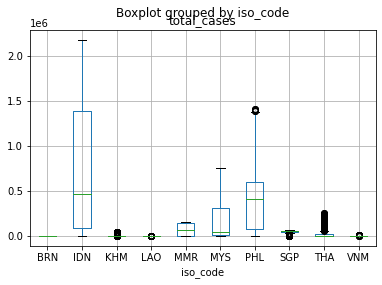

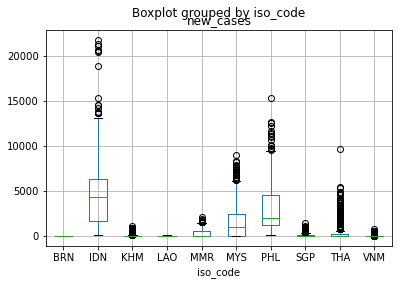

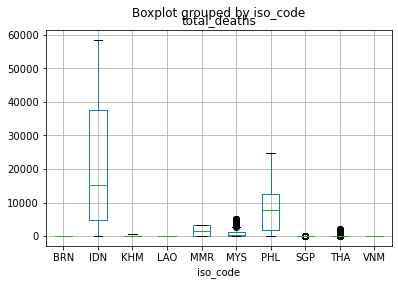

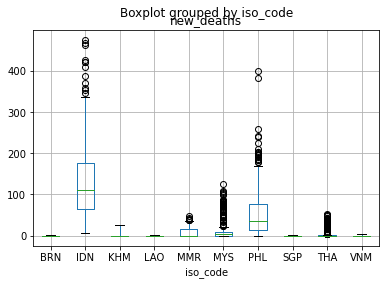

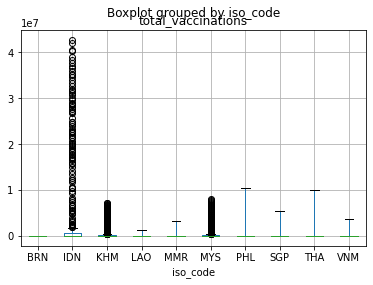

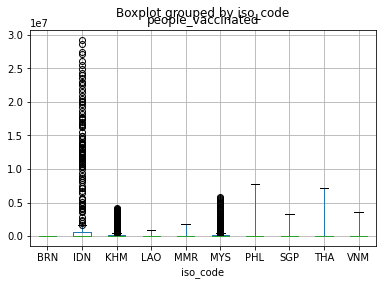

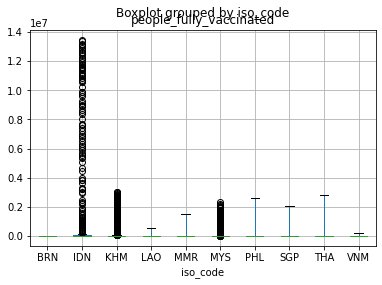

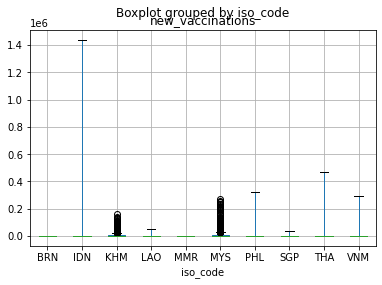

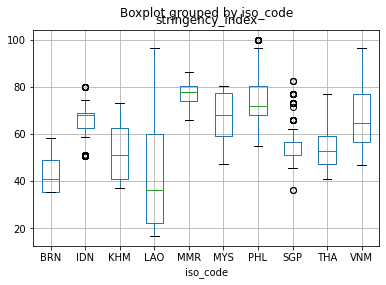

In [6]:
#Checking for outliers (visually)
for i in range (len(toRetainData)-1):
    covid_df.boxplot(column=toRetainData[i], by="iso_code", figsize=(6,4),autorange=True)

### 3. Exploratory Data Analysis

Before the discussion regarding the EDA Questions, the data shall be explored as on an as-is basis to see what do the following contents of the dataframe show.

**COVID Case Numbers**

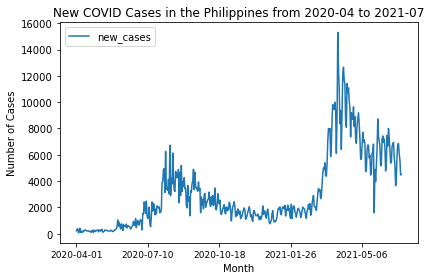

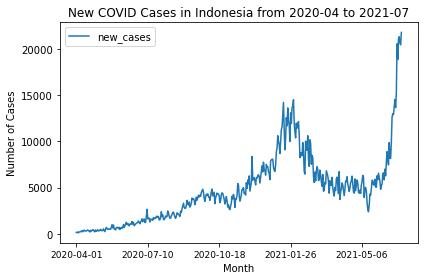

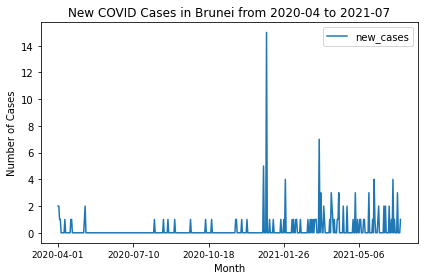

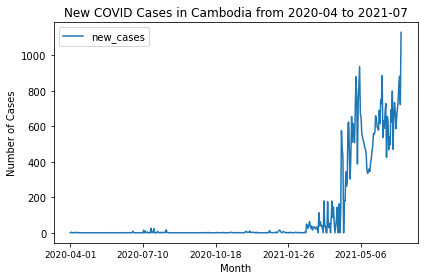

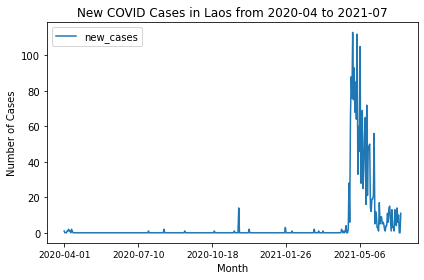

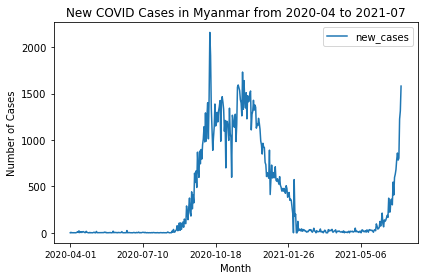

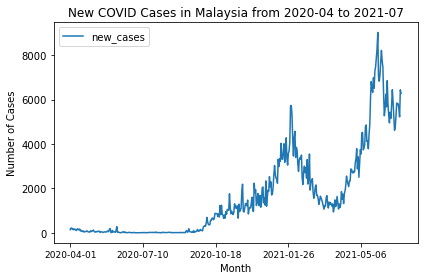

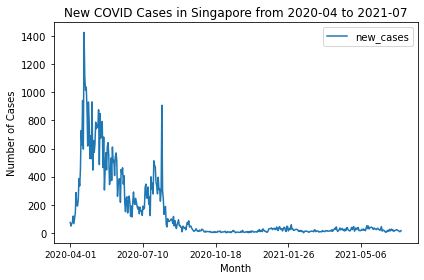

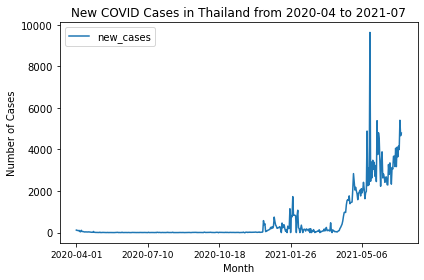

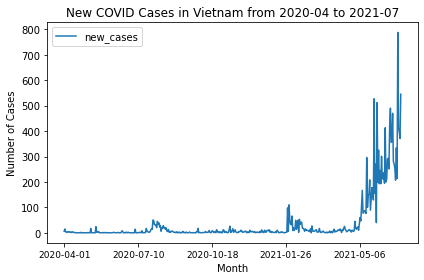

In [7]:
#Returns a line chart based on a country from the covid_df
def createCountryLineChart(df,iso_code, x_param, y_param, xlabel, ylabel, chart_title):
    line_chart = df[df["iso_code"] == iso_code].plot(x=x_param, y=y_param, figsize=(6, 4)) 
    line_chart.set_xticklabels(line_chart.get_xticklabels(), fontsize=9)
    line_chart.set_title(chart_title)
    line_chart.set_xlabel(xlabel)
    line_chart.set_ylabel(ylabel)
    plt.tight_layout()
    return line_chart

PHL_graph = createCountryLineChart(covid_df, "PHL", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in the Philippines from 2020-04 to 2021-07")
IDN_graph = createCountryLineChart(covid_df, "IDN", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Indonesia from 2020-04 to 2021-07")
BRN_graph = createCountryLineChart(covid_df, "BRN", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Brunei from 2020-04 to 2021-07")  
KHM_graph = createCountryLineChart(covid_df, "KHM", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Cambodia from 2020-04 to 2021-07")     
LAO_graph = createCountryLineChart(covid_df, "LAO", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Laos from 2020-04 to 2021-07")
MMR_graph = createCountryLineChart(covid_df, "MMR", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Myanmar from 2020-04 to 2021-07")
MYS_graph = createCountryLineChart(covid_df, "MYS", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Malaysia from 2020-04 to 2021-07")
SGP_graph = createCountryLineChart(covid_df, "SGP", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Singapore from 2020-04 to 2021-07")
THA_graph = createCountryLineChart(covid_df, "THA", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Thailand from 2020-04 to 2021-07")  
VNM_graph = createCountryLineChart(covid_df, "VNM", "date", "new_cases", "Month", "Number of Cases", "New COVID Cases in Vietnam from 2020-04 to 2021-07")  

It could be observed that the majority of the ASEAN nations (including the Philippines) experience a definite increase in their daily new_cases well after the start of 2021. This could be attributed more to the fact that these nations are trying to open up a bit more to recover the lost economic activity from 2020 as well as the entry of a more dangerous variant of COVID-19 on the following nation's borders. The following chart shows the stringency index of all of ASEAN from April 2020 up to before July of 2021 to support the assumption of reasons as to why COVID cases have risen this 2021.

Additionally, ever since COVID-19 has emerged in late 2019, different variants of COVID-19 have also emerged and according to WHO it could possibly make the virus more contagious and deadlier. The list of variants of concern are the following: Alpha, Beta, Gamma, & Delta variants. All of which have reached the Philippines and some if not all nations in ASEAN. The Philippine government also did announce that the Lambda variant will be also closely monitored, due to increased concerns from other countries, along side the Delta variant (Parrocha, 2021).

Another thing to consider is that case numbers are potentially related to the number of people in the country as it makes it easier for the virus to spread from person to person since there are a lot of people that can be involved in the infection process. With the countries of Indonesia and the Philippines being the largest, exceeding 100 million people, and with Singapore and Brunei being the smallest at around 5.8 million and 437 thousand respectively.

In [8]:
covid_df[covid_df['date']=='2021-01-01'][['iso_code','population']]

,iso_code,population
13874,BRN,437483.0
15866,KHM,16718971.0
43219,IDN,273523621.0
51135,LAO,7275556.0
56722,MYS,32365998.0
63790,MMR,54409794.0
73848,PHL,109581085.0
82646,SGP,5850343.0
92127,THA,69799978.0
100200,VNM,97338583.0


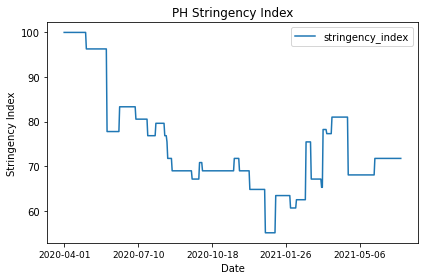

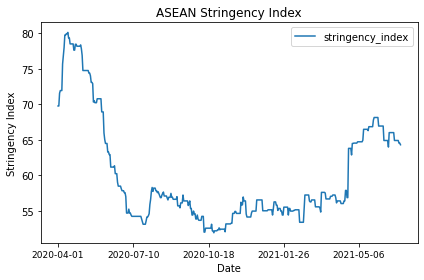

In [9]:
ph_stringencyGraph = createCountryLineChart(covid_df,'PHL', 'date', 'stringency_index', 'Date', 'Stringency Index', 'PH Stringency Index')
asean_stringencyGraph = createCountryLineChart(group_df,'MDL_SEA', 'date', 'stringency_index', 'Date', 'Stringency Index', 'ASEAN Stringency Index')

**EDA Questions:**<br>
1. Do case trends (new_cases) in the Philippines differ to ASEAN every month period.
2. Is there a correlation between the new cases to new deaths?
3. Do case numbers correlate negatively with the number of people being vaccinated?

**1. Do case trends (new_cases) in the Philippines significantly differ to other ASEAN nations on a monthly average?**<br>

Compares PH monthly case trend on a monthly average and checks if there is a significant differences against the same monthly average of ASEAN.

The following code block will find the respective CI values of the Philippines' new cases per month and will compare it to the overall new cases reported by all of ASEAN member nations (including the Philippines).

The general formula for both population and sample size will be $s=d*n$ ($c$=country, $d$=days with report), thus the population size of ASEAN will be around $\geqslant300$ (~30 days with 10 countries) and the Philippines expected to be $~30$.

The statistical parameters will be set at 95% confidence level at a two-tailed approach.

In [10]:
def findMonthlyNewCases(df,grouping,mode,asDataFrame): #REFACTORED CODE BY JASON FOR REUSABILITY
    df.groupby('iso_code')
    df['date'].str[:7]
    df = df.assign(year_month = df['date'].str[:7])
    list = df.groupby(grouping).new_cases.agg(mode)
    if asDataFrame:
        return pd.DataFrame(list).reset_index()
    else:
        return list

#Add a "year_month" column based on "date" column
df_indiv_monthly_totals = findMonthlyNewCases(covid_df,['iso_code','year_month'],['sum','mean','std'],True)
df_ph_monthly_totals = findMonthlyNewCases(ph_df,['iso_code','year_month'],['sum','mean','std'],True)

print("ASEAN Nation's Monthly New Cases:\n",df_indiv_monthly_totals.tail(5),"\n")

ASEAN Nation's Monthly New Cases:
     iso_code year_month     sum        mean         std
145      VNM    2021-02   631.0   22.535714   17.123694
146      VNM    2021-03   155.0    5.000000    5.709641
147      VNM    2021-04   325.0   10.833333    8.271610
148      VNM    2021-05  4504.0  145.290323  128.280212
149      VNM    2021-06  9620.0  320.666667  132.494199 



<AxesSubplot:title={'center':'mean'}, xlabel='year_month'>

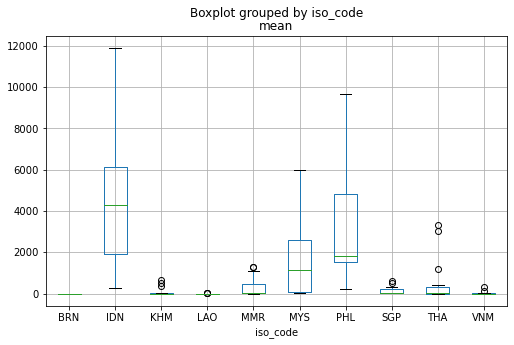

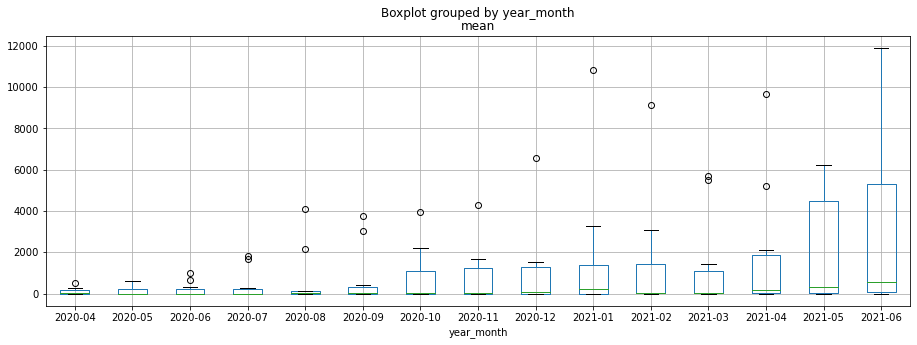

In [11]:
#VISUALIZATIONS
df_indiv_monthly_totals.boxplot("mean", by="iso_code", figsize=(8,5),autorange=True) #new_cases mean per iso_code
df_indiv_monthly_totals.boxplot("mean", by="year_month", figsize=(15,5),autorange=True)#new_cases mean per year_month

The visualization shows ranges of the monthly average of new cases of COVID-19 being reported by every nation in the ASEAN. Based from the visualization, the top 3 countries with the highest monthly average of new cases are the **Indonesia, the Philippines, and Malaysia**. This is despite of the countries increasing vaccination rate as shown in the third graph but it seems that it is not enough given the population of the Philippines of around 109 million people (Mapa, 2021). The boxplot also shows that there are potential outliers in the data shown, however this could be considered more of a spike in cases rather than an outlier but it must be considered as well that **governments may have done changes on their method of recording or may have made mistakes on their reported new case numbers** that may have caused the supposed outliers.

From the results, the month of July 2021 will be ommitted given that the lower and upper confidence intervals are NaN, because the only value available there is the 1st of July, as the result of date synchronization that was done in data cleaning. Additionally the resulting NaN is caused by the fact that $n=1$ and $std=\sqrt{ \frac{ \sum x-x^{2} }{n-1} }$ with $n-1$ resulting to $0$.

<AxesSubplot:title={'center':'COVID Cases in the ASEAN Community from 2020-04 to 2021-07'}, xlabel='Month', ylabel='Number of Cases'>

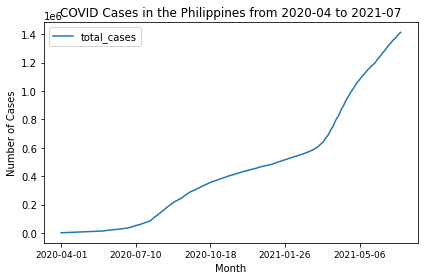

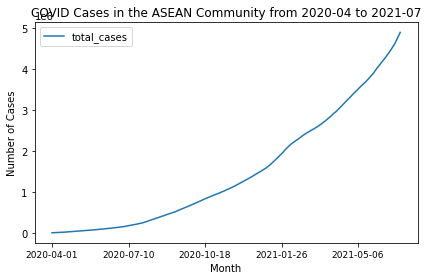

In [12]:
createCountryLineChart(covid_df, "PHL", "date", "total_cases", "Month", "Number of Cases", "COVID Cases in the Philippines from 2020-04 to 2021-07")
createCountryLineChart(group_df,"MDL_SEA","date","total_cases", "Month", "Number of Cases", "COVID Cases in the ASEAN Community from 2020-04 to 2021-07")

In whole, both the Philippines and ASEAN experience a definite increase in its total cases as shown in the graph above, however this does not necessarily point out that the Philippines is the sole reason for the rise of total cases in the region but rather could be only pointed out as a potential contributor to it.

**2. Is there a correlation between the new cases to new deaths?**

This EDA questions aims to show whether there is a relationship of an economy of country and their capability to provide healthcare to their citizens.

To visually represent this, a scatter plot was decided to best show (at a glance) on how cases correlate to the number of new vaccinations being inocculated to Filipinos at the time this was made. The each corner (quadrants) of the scatter plot shows the four following scenarios:
1. Upper-Right (Quadrant 1): High Deaths, High Cases
2. Upper-Left (Quadrant 2): Low Deaths, High Cases
3. Lower-Left (Quadrant 3): Low Deaths, Low Cases
4. Lower-Right (Quadrant 4): High Deaths, Low Cases

From this, the government should aim for the third quadrant since it suggests that it might be possible for it to have a low death rate if there are low cases in the first place. Though it should be worth noting as well that the reports regarding new deaths come at a later period from the date of reporting a case for a person that belongs to both categories of data.

R Value: 0.5929172454608268


<AxesSubplot:xlabel='new_deaths', ylabel='new_cases'>

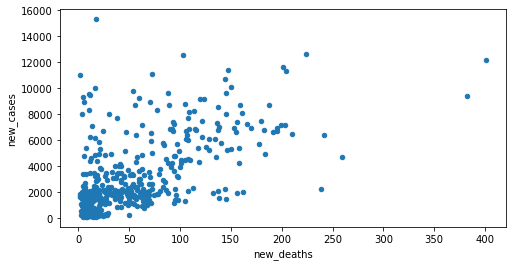

In [13]:
forCorr = ph_df[['date','new_cases','new_deaths','year_month']]
forCorr = forCorr[(forCorr['new_cases'] != 0)&(forCorr['new_deaths'] != 0)] #Removing zero valued new_deaths, since there are no vaccinations during that time

corr = stat.pearsonr(forCorr['new_deaths'].tolist(),forCorr['new_cases'].tolist())
print("R Value:",corr[0])
forCorr.plot.scatter('new_deaths','new_cases',figsize=(8,4)) #Philippines' New Cases to New Vaccinations Scatter Plot

**3. Do case numbers correlate negatively with the number of people being vaccinated?**

To visually represent this, a scatter plot was decided to best show (at a glance) on how cases correlate to the number of new vaccinations being inocculated to Filipinos at the time this was made. The each corner (quadrants) of the scatter plot shows the four following scenarios:
1. Upper-Right (Quadrant 1): High vaccination rate, High new cases
2. Upper-Left (Quadrant 2): Low vaccination rate, High new cases
3. Lower-Left (Quadrant 3): Low vaccination rate, Low new cases
4. Lower-Right (Quadrant 4): High vaccination rate, Low new cases

Ideally, governments should aim for the **fourth quadrant** scenario at should steer away from reaching either of the first two quadrants.

R Value: -0.11738150553819919


<AxesSubplot:xlabel='new_vaccinations', ylabel='new_cases'>

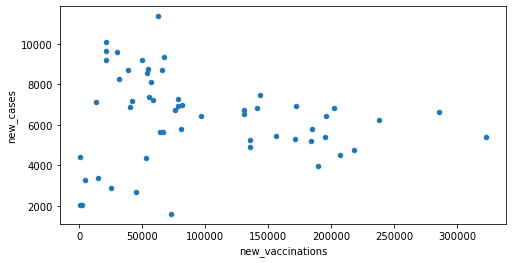

In [14]:
forCorr = ph_df[['date','new_cases','new_vaccinations','year_month']]
forCorr = forCorr[(forCorr['new_cases'] != 0)&(forCorr['new_vaccinations'] != 0)] #Removing zero valued new_vaccinations, since there are no vaccinations during that time

corr = stat.pearsonr(forCorr['new_vaccinations'].tolist(),forCorr['new_cases'].tolist())
print("R Value:",corr[0])
forCorr.plot.scatter('new_vaccinations','new_cases',figsize=(8,4)) #Philippines' New Cases to New Vaccinations Scatter Plot

The visualization shows that the Philippines belongs mostly on the center middle and upper left part of the scatter plot, indicating that vaccinations, for the moment, aid in reducing the number of new cases from arising. This relationship is also attributed to people following health protocols such as wearing face masks and practicing social distancing. However, the number of people vaccinated is still at 11.7M people (Kabagani, 2021), which is still tens of millions away from the target herd immunity of 70% of a country's population (Swaminathan & Gupta-Smith, 2020).

Additionally, using scipy's pearsonr(), the data resulted to an r-value of $r=-0.1174$ which according to the Guildford Rule of Thumb is a (negative) negligable relationship (Hinkle et. al., 2003). It could be assumed that, as of the moment, vaccinations do not yet reflect that of the expected reduction in case numbers of COVID-19 in the Philippines. This could be attributed to either:
1. Still lacking number of COVID-19 vaccines given the population
2. Emergence of new COVID-19 variants
3. Weaknesses of vaccines used in certain variants (Hewings-Martin, 2021)

For the moment, the following vaccines are currently used in the Philippines as approved by the FDA (*Emergency Use Authorization*, 2021) with the respective quantity as tracked by ABS-CBN at July 26, 2021 (*Philippines: COVID-19 Vaccine Tracker*, 2021):

|Vaccine|Quantity (Donated & Procured)|% of Vaccine Pool|
|---|---|---|
|Pfizer-BioNTech|3,410,550|11%|
|Oxford-AstraZeneca|6,858,900|22%|
|Coronavac Sinovac|17,000,000|54%|
|Sputnik V|350,000|1%|
|Janssen-J&J|3,240,850|10%|
|Bharat Biotech-Covaxin|
|Moderna|500,400|2%|
|*Novavax|

Despite this, government health departments/ministries as well as WHO do advice the public to still get vaccinated as soon as it is available since having a vaccine is far better than not having a vaccine taken in the first place.

*Notes:*
1. Novavax awaiting EUA
2. The data does not include those purchased by the private sector
3. Most vaccines require at least 2 doses for full effectivity with J&J-Janssen's vaccines requiring only 1 dose for its full effectiveness.

### 4. Research Question

**1. Is there a significant difference between the Philippines and ASEAN member nations in the monthly average of new COVID-19  cases?**

1. Scope in Dataset: New cases of all ASEAN nations with the Philippines being the "sample". The data will be aggregated on an average monthly basis of new cases to see the monthly rate of new cases being recorded between the Philippines and ASEAN.
2. Significance: This is in order to know how the Philippines fare against COVID-19 (whether lower or higher in new case numbers) in comparison to our neighboring countries in the ASEAN as well as in the world such that if there is a significant difference. This should help us determine if the government is doing well enough action in order mitigating the risk and reducing the number of COVID-19 cases in the country.

**2. Is there a significant difference between those that received the the prescribed doses of the COVID-19 vaccine against those that only received 1 dose (specifically for 2 dose vaccines)?**<br>

1. Scope of the Data: It will make use the data that is found in people_vaccinated and people_fully_vaccinated in the dataset.
2. Significance: This question aims to determine if there are is a significant difference between people who have been vaccinated only once versus those that receive all of the prescribed doses. This also will look into

### 5. Statistical Inference

**For Research Question 1:** Is there a significant difference between the Philippines and ASEAN member nations in the monthly average of new COVID-19 cases?<br>

$H_0 = $ There is no difference between the Philippines and the whole of ASEAN member nations on their monthly average of new COVID-19 cases.<br>
$H_A = $ There is a difference between the Philippines and the whole of ASEAN member nations on their monthly average of new COVID-19 cases.

For this research question, the confidence interval was first checked in order to determine on where the Philippines is in terms of new COVID-19 cases against the whole of ASEAN.

The statistical parameters set for this as well as for succeeding tests are:
- Confidence Level = 95%
- Significance Level = 5%

The sampling method for this question is purposive sampling, with its purpose of only determining how the Philippines is doing in relation to its neighbors in the association.

In [27]:
#CONFIDENCE INTERVAL LEVELS FOR VISUAL CHECKING
year_month = (covid_df['date'].str[:7]).unique().tolist()
    
#TO MEET THE MINIMUM QUANTITY OF 30 SAMPLES FROM A POPULATION
#DataFrames to use: covid_df (population) and ph_df (sample); Purposive sampling
#iterative per year_month[i]
#find date_df[i] = covid_df[covid_df['date'].str.contains(year_month[i])] => all entries for that month regardless of country (still part of ASEAN); expect ~30*10 entries
#find ph_date_df[i] = ph_df[ph_df['date'].str.contains(year_month[i])] => as sample from covid_df; expect ~30+ entries
#agg[mean,std] for every year_month of date_df and ph_date_df
#@95% confidence; 0.975

def margin_error(z,std,n): #(z_val, sample_std, sample_size)
    return z*(std/math.sqrt(n))
def CI(m, e): #(sample_mean,sample_mgerr)
    return [m-e,m+e]

#statistical parameters
confidence = 0.95
significance = 1-confidence
z_val = stat.norm.ppf(1-significance/2) #two-tail; remove '/2' if one-tailed
print("Confidence Value:",confidence)
print("Z-Val:",z_val)

#placeholders; for visualization purposes
lo_ci=[]; hi_ci=[]
asean_monthly=[]; ph_monthly=[]

#statistical treatment
for i in range(len(year_month)):
    #dataframes to use
    asean_date_df = (covid_df[covid_df['date'].str.contains(year_month[i])]).reset_index()
    ph_date_df = (ph_df[ph_df['date'].str.contains(year_month[i])]).reset_index()
    #aggregations
    asean_agg_df = asean_date_df.agg({'new_cases':['mean','std']})#population
    ph_agg_df = ph_date_df.agg({'new_cases':['mean','std']})#sample
    asean_monthly.append(asean_agg_df['new_cases']['mean']) #list of pop means
    ph_monthly.append(ph_agg_df['new_cases']['mean'])
    n=ph_date_df.shape[0]
    err=margin_error(z_val,asean_agg_df['new_cases']['std'],n)#margin of error
    ci=CI(asean_agg_df['new_cases']['mean'],err)
    print(ci)
    lo_ci.append(ci[0]); hi_ci.append(ci[1])

treated = {'year_month':year_month,'lo_ci':lo_ci,
           'asean_monthly':asean_monthly,'ph_monthly':ph_monthly,
           'hi_ci':hi_ci
          }

ph_asean_ncase_df = pd.DataFrame(treated,columns=['year_month','lo_ci','ph_monthly','hi_ci','asean_monthly'])
ph_asean_ncase_df['in_range'] = np.where((ph_asean_ncase_df['lo_ci']<= ph_monthly)&(ph_asean_ncase_df['hi_ci'] >= ph_monthly),'Within','Not Within')
ph_asean_ncase_df['in_range'].value_counts()

Confidence Value: 0.95
Z-Val: 1.959963984540054
[42.88378508330888, 190.46288158335778]
[63.70180103431923, 237.904650578584]
[72.32615593051673, 323.61384406948326]
[118.223937845178, 636.3631589290155]
[164.1151943823922, 1126.291257230511]
[233.57947243994312, 1223.9405275600568]
[358.04107172022793, 1269.958928279772]
[357.30734700143427, 1326.0126529985657]
[378.00249965294756, 1761.9587906696331]
[506.06725480507725, 2835.816616162665]
[389.6781384586202, 2484.6290043985227]
[450.1340484661698, 2120.0724031467334]
[745.4929785575086, 2984.4070214424914]
[1105.8195733543157, 2949.315910516652]
[1362.3576112279889, 4386.122388772011]


Not Within    12
Within         3
Name: in_range, dtype: int64

R: ASEAN LoCI
G: PH Mean
B: ASEAN HiCI
Y: ASEAN Mean


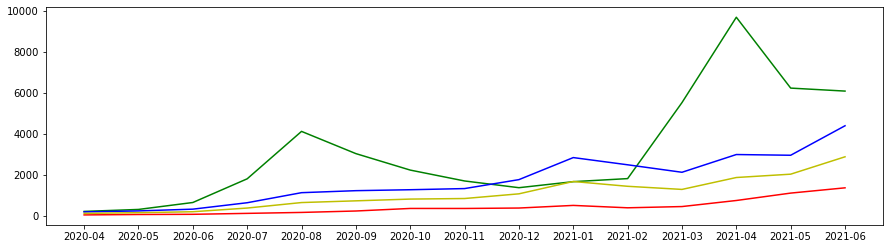

In [30]:
#PLOTTING CONFIDENCE INTERVAL LEVELS ALONGSIDE ASEAN NEW CASE MEAN
plt.figure().set_figwidth(15)
def prepLineGraph(x,y,c): #Referenced from https://www.geeksforgeeks.org/matplotlib-pyplot-axvline-in-python/
    plt.plot(x,y,color=c)

print("R: ASEAN LoCI\nG: PH Mean\nB: ASEAN HiCI\nY: ASEAN Mean")
prepLineGraph(ph_asean_ncase_df['year_month'].tolist(),ph_asean_ncase_df['lo_ci'].tolist(),'r')
prepLineGraph(ph_asean_ncase_df['year_month'].tolist(),ph_asean_ncase_df['ph_monthly'].tolist(),'g')
prepLineGraph(ph_asean_ncase_df['year_month'].tolist(),ph_asean_ncase_df['hi_ci'].tolist(),'b')
prepLineGraph(ph_asean_ncase_df['year_month'].tolist(),ph_asean_ncase_df['asean_monthly'].tolist(),'y')

Based from the resulting confidence intervals and its subsequent graph, it could be well determined that the Philippines is above the average of ASEAN in new cases of COVID-19, with only time of us being well within the average during December 2020 to February 2021. 

To further expound this initial claim, an individual t-test will be conducted with the same data to determine if there are any significant differences between the averages of the Philippines and ASEAN. For this, scipy's ttest_rel() was used.

According to scipy's documentation, this test is a two sided test where the null hypothesis is that there are two related or repeated samples which have identical average values. Apart from this however, it is acknowledged that the Philippines is a part of the ASEAN community, therefore it could be well considered that both the data of ASEAN and the Philippines are related to each other.

In [17]:
#Individual T-Test (Dependent via ttest_rel)
ttestResult = stat.ttest_ind(ph_asean_ncase_df['asean_monthly'],ph_asean_ncase_df['ph_monthly']) #TTest for Related 
print("t-Test P-Value:",ttestResult.pvalue)
print("Significance:",significance)
print("t-Test < Significance: ", ttestResult.pvalue<significance)

t-Test P-Value: 0.009630600317844802
Significance: 0.050000000000000044
t-Test < Significance:  True


Since the return value of the p-value is $p=0.01$ which is less than the significance value of $\alpha=0.05$. Thus, the null hypothesis is rejected, therefore there is **no significant difference between the monthly average new case numbers of the Philippines and the ASEAN community as a whole on a monthly basis**. This, despite the previously shown graph that the Philippines is above the ASEAN community on the monthly new cases in most months.

**For Research Question 2:** Is there a significant difference between those that received the the prescribed doses of the COVID-19 vaccine against those that only received 1 dose (specifically for 2 dose vaccines)?<br>

$H_0 = $ There is no significant difference between fully vaccinated and vaccinated people.<br> 
$H_A = $ There is a significant difference between fully vaccinated and vaccinated people.<br>

The requirement for statistical inference for categorical data is that all totals of the category must be equal on all groups involved. In this case the 'groups' are the individual countries in ASEAN, and the 'categories' are whether the people people that received the vaccine only received one dose or both doses.

To do this, another column has to be made in the dataframe (covid_df) in order to determine the first dose only vaccinations that have been conducted to a country's population afterwhich another column is then made to determine as to what is more prominent in terms of the vaccination stage from the population that was vaccinated. Effectively there are already categories in the list whether the country has reached vaccinees that belong more Full Vaccinations or Partial Vaccinations.

<AxesSubplot:title={'center':'people_fully_vaccinated'}, xlabel='iso_code'>

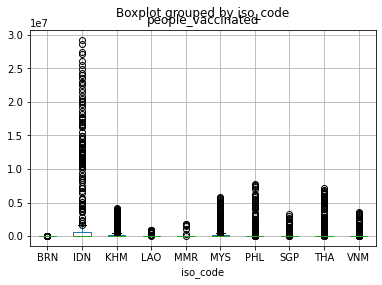

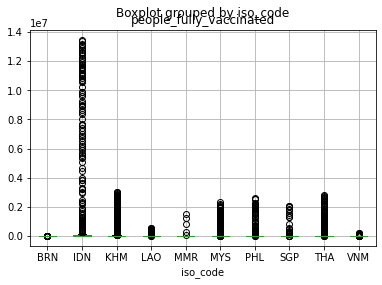

In [18]:
covid_df.boxplot('people_vaccinated',by='iso_code')
covid_df.boxplot('people_fully_vaccinated',by='iso_code')

The outliers shown in the data is primarily because of the data being mostly zeroes, since the vaccination came in starting 2021 thus leaving the year of 2020 full with zero values. From this the outliers (zeroes) are to be removed on the following code which will then be validated by another boxplot.

The process involves removing zero valued observations as well as creating two new columns whcihc are people_partially_vaccinated (which is the difference between people_vaccinated and people_fully_vaccinated) and vacc_state which is a binned version of the numbers between people_partially_vaccinated and people_fully_vaccinated which indicate who among the vaccinees are most dominant in a certain country.

<AxesSubplot:title={'center':'people_fully_vaccinated'}, xlabel='iso_code'>

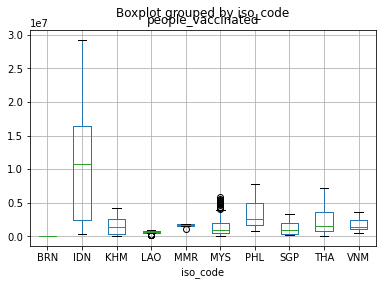

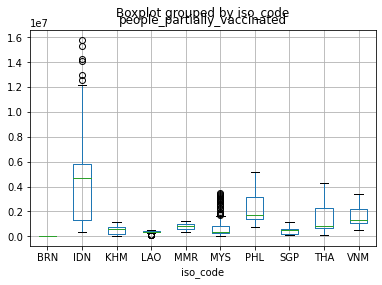

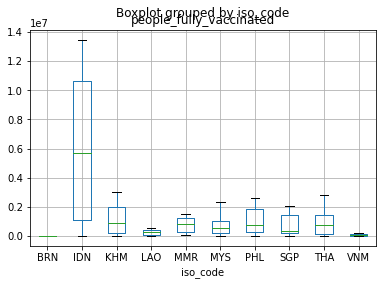

In [19]:
vacc_df = covid_df[(covid_df['people_vaccinated']!=0)&(covid_df['people_fully_vaccinated']!=0)] #removing zero-valued vaccinations
vacc_df = vacc_df.assign(people_partially_vaccinated = lambda x: x['people_vaccinated']-x['people_fully_vaccinated']) #based on owid's graph implying
vacc_df['vacc_state'] = np.where(vacc_df['people_partially_vaccinated']>vacc_df['people_fully_vaccinated'],'Partial','Full')
vacc_df.boxplot('people_vaccinated',by='iso_code')
vacc_df.boxplot('people_partially_vaccinated',by='iso_code')
vacc_df.boxplot('people_fully_vaccinated',by='iso_code')

For the most part, certain countries still have outliers even after removal of the zero values are done.

In [20]:
print(vacc_df['iso_code'].value_counts())
vacc_df[['iso_code','people_partially_vaccinated','people_fully_vaccinated','vacc_state']].head(5)

KHM    124
MYS    123
IDN    121
THA     89
PHL     53
LAO     44
BRN     37
VNM     36
SGP     25
MMR      5
Name: iso_code, dtype: int64


,iso_code,people_partially_vaccinated,people_fully_vaccinated,vacc_state
13989,BRN,12737.0,105.0,Partial
13990,BRN,13241.0,122.0,Partial
13991,BRN,13670.0,228.0,Partial
13992,BRN,14176.0,350.0,Partial
13996,BRN,14181.0,862.0,Partial


The results above show that the vacc_df will only be limited to 5 entries of samples

In [21]:
def getSample(src_df, group_list, n):
    single = []; full = []
    for i in range(len(group_list)):
        df = src_df[src_df['iso_code']==group_list[i]].sample(n,replace=False)['vacc_state'].value_counts() #random sample by country
        for i in range(df.index.size):
            if(df.index[i] == 'Full'):
                full.append(df['Full'])
            if(df.index[i] == 'Partial'):
                single.append(df['Partial'])
        if len(single)<len(full):
            single.append(0)
        elif len(single)>len(full):
            full.append(0)
    return [single,full]
def state(a,b):
    if a<b:
        return "Full"
    else:
        return "Partial"

c = getSample(vacc_df,vacc_df['iso_code'].unique().tolist(),5)
single_vacc = c[0].copy()
full_vacc = c[1].copy()

print("covid_df iso_code:",vacc_df['iso_code'].unique())
for i in range(vacc_df['iso_code'].unique().size):
    print(vacc_df['iso_code'].unique().tolist()[i],":",single_vacc[i],",",full_vacc[i],",",state(single_vacc[i],full_vacc[i]))

print("\n")

combined = [single_vacc,full_vacc]
#will make use of this: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html
chi = stat.chi2_contingency(combined)
print("chi2:",chi[0])
print("pval:",chi[1],"< 0.05 =",chi[1]<0.05)
print("dof:",chi[2])#should be 9 since df=(categories-1)(groups-1)=(2-1)(10-1)=1*9=9; 2categories, 10groups

#print("     partially vaccinated , fully vaccinated")
#for i in range(vacc_df['iso_code'].unique().size):
#    print(vacc_df['iso_code'].unique().tolist()[i],"=",chi[3][0][i],",",chi[3][1][i])

covid_df iso_code: ['BRN' 'KHM' 'IDN' 'LAO' 'MYS' 'MMR' 'PHL' 'SGP' 'THA' 'VNM']
BRN : 5 , 0 , Partial
KHM : 3 , 2 , Partial
IDN : 2 , 3 , Full
LAO : 3 , 2 , Partial
MYS : 3 , 2 , Partial
MMR : 2 , 3 , Full
PHL : 5 , 0 , Partial
SGP : 2 , 3 , Full
THA : 4 , 1 , Partial
VNM : 5 , 0 , Partial


chi2: 13.235294117647058
pval: 0.1522452816682046 < 0.05 = False
dof: 9


The resulting p-value is less than the significance value of 0.05, therefore **there is a significant difference between those that are vaccinated in once to those that have received the recommended dosage prescribed by the vaccine manufacturer**. For the most part however, it should be considered that there will be a time that it may say that it is significantly different on the context of having a higher number of fully vaccinated than those who just received a single dose, which could indicate that the governments of these countries are approaching their full vaccination numbers similar to those of their country's population.

### 6. Insights and Conclusions

COVID-19 has brought about a massive change in the lives of all people including the people of member nations of ASEAN. It has caused tens of thousands of deaths in the region. It also brought about a big dent on the country's economy due to the lockdowns imposed by the government in order to curb the spread of COVID-19.

In terms of the case numbers, it was determined that there was a significant difference in the monthly average of reported new cases in the Philippines in comparison to ASEAN. This causes could be attributed to new variants that are spreading throughout the world, including the ASEAN region. Another thing that should be considered is the continous reduction of every government's stringency for the purposes of allowing their respective economies to function back in near pre-COVID levels to recoup the losses made during 2020. With this however, the public is still well encouraged to stringently abide by the health protocols as well as taking the opportunity of having oneself be vaccinated as this are only the scientifically sound ways of dealing and eventually eradicating the virus.

*CONTENTS FOR RESEARCH QUESTION 2*

### Sources

- Emergency Use Authorization. Food and Drug Administration - Philippines. (2021, July 11). https://www.fda.gov.ph/list-of-fda-issued-emergency-use-authorization/.
- Hewings-Martin, Y. (2021). COVID-19: Which vaccines are effective against the delta variant? Retrieved from: https://www.medicalnewstoday.com/articles/covid-19-which-vaccines-are-effective-against-the-delta-variant
- Hinkle, D. E., Wiersma, W., & Jurs, S. G. (2003). Applied Statistics for the Behavioral Sciences. Boston, MA: Houghton Mifflin Company.
- Kabagani, L.J. 2021. Over 11.7M now vaccinated in PH. Retrieved from https://www.pna.gov.ph/articles/1146011
- Mapa, D. S. (2020). Highlights of the Population Density of the Philippines 2020 Census of Population and Housing (2020 CPH). Retrieved from: https://psa.gov.ph/population-and-housing/node/164857
- Mathieu, E., Ritchie, H., Ortiz-Ospina, E. et al. A global database of COVID-19 vaccinations. Nat Hum Behav (2021)
- Parrocha, A. (2021). Delta, Lambda Covid-19 variants cause of concern: PRRD. Retrieved from https://www.pna.gov.ph/articles/1146832
- Philippines: COVID-19 Vaccine Tracker. (2021). Retrieved from: https://news.abs-cbn.com/spotlight/multimedia/infographic/03/23/21/philippines-covid-19-vaccine-tracker
- Swaminathan, S. & Gupta-Smith, V. (2020). Episode #1 - Herd immunity. Retrieved from: https://www.who.int/emergencies/diseases/novel-coronavirus-2019/media-resources/science-in-5/episode-1
- Tracking SARS-CoV-2 variants. (2021). Retrieved from: https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/